## Nuclear Masses

In [6]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd
import emcee
from tqdm import tqdm
import corner


### Bayesian Inference

In [17]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

In [18]:
def model(a_v,a_s,a_c,a_a,N,Z):
    A = N + Z
    return (a_v*A - a_s*A**(2/3) - a_c*Z*(Z-1)/(A**(1/3)) - a_a*((N-Z)**2)/A)/A

## EMCEE

In [19]:
# Parameters
param_names = ['a_v', 'a_s', 'a_c', 'a_a']

def loglikelihood(params):
    (a_v, a_s, a_c, a_a) = params
    log_like = -np.sum(((model(a_v, a_s, a_c, a_a, N, Z) - BE)/BE_err)**2 + np.log(2*np.pi*BE_err**2)) / 2. 
    return log_like
    
def prior(params):
    (a_v, a_s, a_c, a_a) = params

    if (
        0 < a_v < 50 and
        0 < a_s < 50 and
        0 < a_c < 3 and
        0 < a_a < 40
    ):
        return 0

    return -np.inf

def log_post(params):
    if not np.isfinite(prior(params)):
        return -np.inf
    return loglikelihood(params)

In [20]:
ndim = 4
nwalkers = 30

p0 = np.array([0, 0, 0, 0]) + np.random.rand(nwalkers, ndim) * np.array(
    [30, 30, 3, 40]
)

In [21]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=())
sampler.run_mcmc(p0, 5000, progress=True)

100%|██████████| 5000/5000 [00:36<00:00, 135.73it/s]


State([[1.18910189e+01 1.14462295e+01 9.03411327e-02 7.14613023e-14]
 [1.18910187e+01 1.14462291e+01 9.03411241e-02 4.18872412e-14]
 [1.18910190e+01 1.14462297e+01 9.03411299e-02 1.43890548e-13]
 [1.18910188e+01 1.14462295e+01 9.03411277e-02 3.92493930e-14]
 [1.18910189e+01 1.14462295e+01 9.03411313e-02 3.35226721e-13]
 [1.18910189e+01 1.14462296e+01 9.03411236e-02 2.91138649e-14]
 [1.18910188e+01 1.14462294e+01 9.03411155e-02 1.15262226e-14]
 [1.18910188e+01 1.14462294e+01 9.03411087e-02 1.62397633e-13]
 [1.18910189e+01 1.14462296e+01 9.03411260e-02 1.08509941e-13]
 [1.18910188e+01 1.14462292e+01 9.03411173e-02 9.57702055e-14]
 [1.18910190e+01 1.14462298e+01 9.03411276e-02 2.93471885e-14]
 [1.18910188e+01 1.14462293e+01 9.03411174e-02 1.40724868e-13]
 [1.18910189e+01 1.14462294e+01 9.03411226e-02 1.03069487e-13]
 [1.18910191e+01 1.14462297e+01 9.03411476e-02 2.86190212e-14]
 [1.18910190e+01 1.14462298e+01 9.03411299e-02 3.20158112e-13]
 [1.18910189e+01 1.14462295e+01 9.03411224e-02 2.

Text(0.5, 0, 'step number')

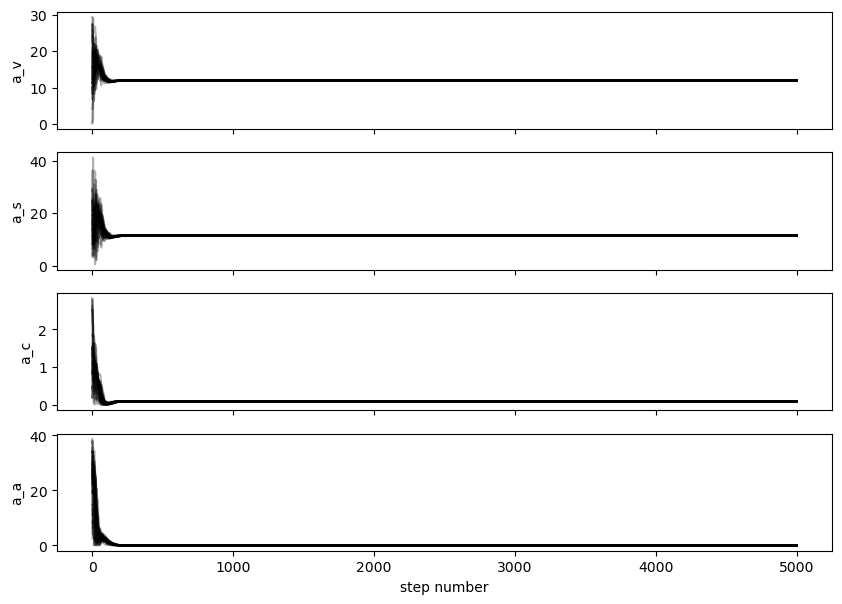

In [22]:
fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for index, ax in enumerate(axs):
    ax.plot(samples[:, :, index], "k", alpha=0.3)
    ax.set_ylabel(["a_v", "a_s", "a_c", "a_a"][index])

axs[-1].set_xlabel("step number")

Quantiles:
[(0.025, np.float64(11.891018690394205)), (0.5, np.float64(11.891018902651382)), (0.975, np.float64(11.891019110831664))]
Quantiles:
[(0.025, np.float64(11.446229051302575)), (0.5, np.float64(11.446229532975101)), (0.975, np.float64(11.446230007270325))]
Quantiles:
[(0.025, np.float64(0.09034110632189851)), (0.5, np.float64(0.0903411251894044)), (0.975, np.float64(0.09034114331025997))]
Quantiles:
[(0.025, np.float64(2.2723783630440876e-15)), (0.5, np.float64(6.299882999985657e-14)), (0.975, np.float64(3.3694776279820494e-13))]


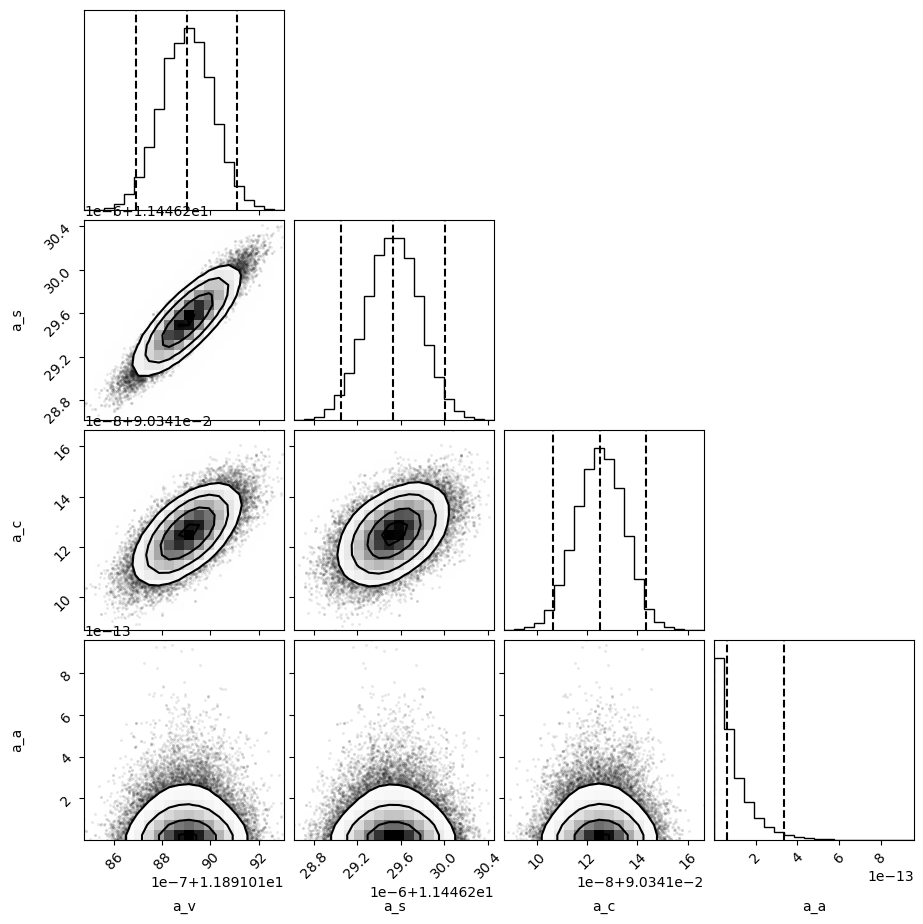

In [24]:
flat_samples = sampler.get_chain(discard=1000, thin=3, flat=True)
fig = corner.corner(flat_samples, labels=["a_v", "a_s", "a_c", "a_a"], verbose=True, plot_contours=True, quantiles=[0.025, 0.5, 0.975], smooth=True)